In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import keras
from keras import layers, models, utils

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1) / 255
x_test = x_test.reshape(-1, 28, 28, 1) / 255

In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [ ]:
classes = np.unique(y_train)
num_classes = len(classes)

classes, num_classes

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), 10)

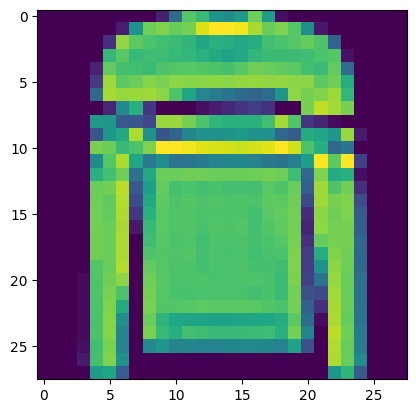

In [ ]:
plt.imshow(x_train[5])

In [ ]:
def residual_block(input_data, filters, stride=1):
    x = layers.Conv2D(filters, kernel_size=(1,1), strides=(stride,stride), padding='valid')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(4*filters, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or input_data.shape[-1] != 4*filters:
        input_data = layers.Conv2D(4*filters, kernel_size=(1,1), strides=(stride,stride), padding='valid')(input_data)
        input_data = layers.BatchNormalization()(input_data)
        
    x = layers.add([input_data, x])
    x = layers.Activation('relu')(x)
    
    return x


def resnet50(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape, name='input')
    x = layers.Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    
    x = residual_block(x, filters=64, stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='ResNet50')
    
    return model

In [ ]:
model = resnet50(input_shape=(28,28,1),num_classes=10)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   3200        ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 64)   0           ['batch_normalization[0][0

In [ ]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
     

In [ ]:
model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=30,
    validation_data=(x_test, y_test),
    shuffle=True,
)
   

Epoch 1/30
235/235 [==============================] - 19s 13ms/step - loss: 0.6228 - accuracy: 0.7846 - val_loss: 3.3160 - val_accuracy: 0.1545
Epoch 2/30
235/235 [==============================] - 2s 10ms/step - loss: 0.3837 - accuracy: 0.8618 - val_loss: 0.7227 - val_accuracy: 0.7407
Epoch 3/30
235/235 [==============================] - 2s 11ms/step - loss: 0.3268 - accuracy: 0.8825 - val_loss: 0.4459 - val_accuracy: 0.8387
Epoch 4/30
235/235 [==============================] - 3s 12ms/step - loss: 0.2991 - accuracy: 0.8920 - val_loss: 0.3463 - val_accuracy: 0.8773
Epoch 5/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2757 - accuracy: 0.9010 - val_loss: 0.6620 - val_accuracy: 0.7707
Epoch 6/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2641 - accuracy: 0.9042 - val_loss: 0.3522 - val_accuracy: 0.8752
Epoch 7/30
235/235 [==============================] - 2s 11ms/step - loss: 0.2486 - accuracy: 0.9096 - val_loss: 0.4029 - val_accuracy: 0.856

In [ ]:
scores = model.evaluate(x_test, y_test)
scores

313/313 [==============================] - 1s 3ms/step - loss: 0.4002 - accuracy: 0.8846


[0.400203138589859, 0.8845999836921692]

In [ ]:
acc = model.evaluate(x_test, y_test)
acc

313/313 [==============================] - 5s 12ms/step - loss: 0.3781 - accuracy: 0.8799


[0.3781186640262604, 0.8798999786376953]

In [ ]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in group_idx
        ]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [
                np.random.choice([i for i in all_groups if i != c_idx])
                for c_idx in group_idx
            ]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in b_group_idx
        ]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

In [ ]:
new_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output, name='FeatureExtractor')
new_model.summary()

Model: "FeatureExtractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   3200        ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 64)   0           ['batch_normalizat

In [ ]:
img_a_in = layers.Input(shape=x_train.shape[1:], name="ImageA_Input")
img_b_in = layers.Input(shape=x_train.shape[1:], name="ImageB_Input")
img_a_feat = new_model(img_a_in)
img_b_feat = new_model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name="merge_features")
combined_features = layers.Dense(256, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(128, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(1, activation="sigmoid")(combined_features)
similarity_model = models.Model(
    inputs=[img_a_in, img_b_in], outputs=[combined_features], name="SimilarityModel"
)
similarity_model.summary()

Model: "SimilarityModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureExtractor (Functional)  (None, 256)          80384       ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 512)          0           ['FeatureExtractor[

In [ ]:
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])
     

1/1 [==============================] - 1s 791ms/step


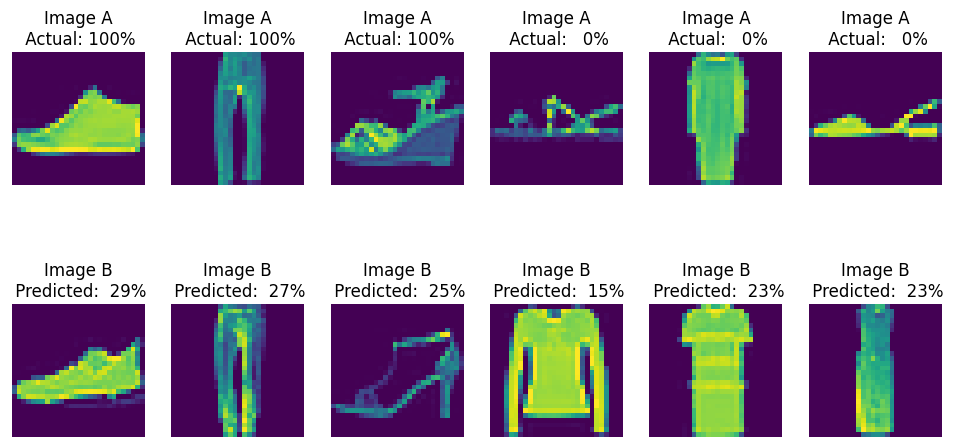

In [ ]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title("Image A\n Actual: %3.0f%%" % (100 * c_d))
        ax1.axis("off")
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title("Image B\n Predicted: %3.0f%%" % (100 * p_d))
        ax2.axis("off")
    return fig


_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size // 2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True,
)
    

Epoch 1/10


<ipython-input-20-7f6e1ae2397c>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(


500/500 [==============================] - 26s 39ms/step - loss: 0.2576 - mae: 0.1650 - val_loss: 0.5028 - val_mae: 0.2149
Epoch 2/10
500/500 [==============================] - 20s 41ms/step - loss: 0.1974 - mae: 0.1219 - val_loss: 0.3056 - val_mae: 0.1483
Epoch 3/10
500/500 [==============================] - 22s 44ms/step - loss: 0.1868 - mae: 0.1135 - val_loss: 0.2220 - val_mae: 0.1234
Epoch 4/10
500/500 [==============================] - 19s 39ms/step - loss: 0.1783 - mae: 0.1075 - val_loss: 0.2260 - val_mae: 0.1235
Epoch 5/10
500/500 [==============================] - 20s 41ms/step - loss: 0.1664 - mae: 0.1011 - val_loss: 0.2027 - val_mae: 0.1163
Epoch 6/10
500/500 [==============================] - 20s 40ms/step - loss: 0.1706 - mae: 0.1022 - val_loss: 0.2009 - val_mae: 0.1158
Epoch 7/10
500/500 [==============================] - 20s 40ms/step - loss: 0.1539 - mae: 0.0931 - val_loss: 0.2267 - val_mae: 0.1209
Epoch 8/10
500/500 [==============================] - 20s 40ms/step - los

In [ ]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size // 2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10


<ipython-input-26-db6e8c2a5a62>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(


500/500 [==============================] - 87s 82ms/step - loss: 0.4787 - mae: 0.3130 - val_loss: 0.4451 - val_mae: 0.2632
Epoch 2/10
500/500 [==============================] - 42s 84ms/step - loss: 0.3546 - mae: 0.2258 - val_loss: 0.3249 - val_mae: 0.2108
Epoch 3/10
500/500 [==============================] - 39s 79ms/step - loss: 0.3198 - mae: 0.2001 - val_loss: 0.4000 - val_mae: 0.1833
Epoch 4/10
500/500 [==============================] - 39s 78ms/step - loss: 0.2982 - mae: 0.1851 - val_loss: 0.3046 - val_mae: 0.1808
Epoch 5/10
500/500 [==============================] - 39s 78ms/step - loss: 0.2924 - mae: 0.1831 - val_loss: 0.3223 - val_mae: 0.1920
Epoch 6/10
500/500 [==============================] - 39s 78ms/step - loss: 0.2809 - mae: 0.1749 - val_loss: 0.2527 - val_mae: 0.1494
Epoch 7/10
500/500 [==============================] - 39s 79ms/step - loss: 0.2638 - mae: 0.1621 - val_loss: 0.2570 - val_mae: 0.1432
Epoch 8/10
500/500 [==============================] - 40s 79ms/step - los

In [ ]:
x_test_features = features_model.predict(x_test, verbose=True, batch_size=256)

40/40 [==============================] - 4s 20ms/step


In [ ]:
x_test_features

array([[0.        , 1.9707644 , 0.        , ..., 1.2269526 , 0.7102758 ,
        3.1905556 ],
       [1.5404681 , 3.301505  , 0.85026747, ..., 3.6720142 , 0.        ,
        0.6258861 ],
       [1.996302  , 0.        , 2.1110487 , ..., 0.        , 0.79527146,
        0.4513482 ],
       ...,
       [0.29520977, 0.        , 0.35888246, ..., 0.        , 2.288532  ,
        0.02834737],
       [2.3672814 , 0.        , 2.3949225 , ..., 0.        , 0.67928904,
        0.96560377],
       [0.        , 0.55311644, 0.        , ..., 2.296604  , 3.9516246 ,
        0.        ]], dtype=float32)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
pca_result = pca.fit_transform(x_test_features)
print('Cumulative explained variation for 40 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 40 principal components: 0.9996676445007324


In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, init="pca")

tsne_result = tsne.fit_transform(pca_result)

tsne_result.shape

(10000, 2)

In [ ]:
categ = {
    1:"T-shirt/top",
    2:"Trouser",
    3:"Pullover",
    4:"Dress",
    5:"Coat",
    6:"Sandal",
    7:"Shirt",
    8:"Sneaker",
    9:"Bag",
    10:"Ankle boot",
}

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_test})
tsne_result_df.label = tsne_result_df.label + 1
tsne_result_df['label'] = [categ.get(x) for x in tsne_result_df['label']]

tsne_result_df.head()

,tsne_1,tsne_2,label
0,63.330738,28.621267,Ankle boot
1,-40.980476,72.300613,Pullover
2,57.002781,-55.198677,Trouser
3,36.621830,-67.930626,Trouser
4,-42.613495,-2.392572,Shirt


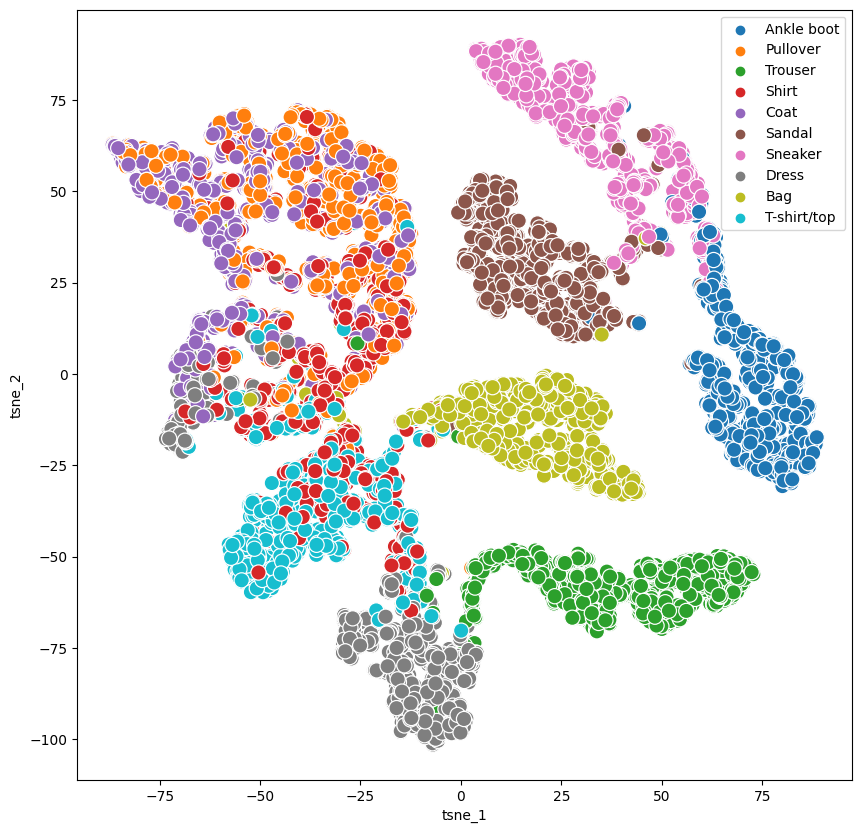

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=120)
ax.legend()